<a href="https://colab.research.google.com/github/jbeen2/Today-I-Learned/blob/main/2020-2-NLP/5-BERT-for-dummies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT
![Transformer](https://blog.kakaocdn.net/dn/Cz2K8/btqCwX7yfGQ/txkY1MEKNklEiDN0x4K9b0/img.png)
* Bidirectional Encoder Representations from Transformers 
* **Attention mechanism**을 사용하는, **Transformer** Encoder-Decoder 기반 모델입니다. 
* BERT는 Transformer 구조에서 **왼쪽, Encoder** 부분만 사용합니다. 

## Positional Encoding 
* Transformer 는 Convolution, Recurrent를 사용하지 않는, **Attention mechanism** 만 사용하여 속도를 향상시킨 모델입니다. 
* 위치 정보가 들어가는 RNN과 달리, Transformer는 **위치 정보**를 추가해 주어야 합니다. 
* 이를 위해 **sin**, **cos** 함수를 사용합니다. 
    - 전체 차원의 수가 짝수일 때는 sin 함수, 홀수일 때는 cos 함수의 값을 따릅니다. 
    - 위치 정보를 정수로 표현하면 모델에 끼치는 영향력이 지나치게 커질 수 있는데, sin, cos 함수를 사용하면 (-1, 1) 값으로 표현되기 때문에 이러한 점을 보완할 수 있습니다. 

```python
# input embedding 
e = self.tok_embed(x) + self.pos_embed(pos) + self.seg_embed(seg)
```

## Multi-Head Attention 
* Encoder Block 의 가장 핵심적인 부분입니다. 
* Attention  
    - Q(현재 단어)와 가장 비슷한 K를 찾은 후, K에 해당하는 V를 찾는 과정입니다. 
        - Q : Query, 찾고자 하는 대상 
        - K : Key, 저장된 데이터를 찾고자 할 때 참조하는 대상 
        - V : Value, 저장되는 데이터
    - K를 통해서는 각 단어와 연관성의 확률을 계산하고, 
    - V는 그 확률을 사용해 attention 값을 계산합니다.     
    - .
    - Recurrent 구조에서는 시간이 흐를수록, 앞의 몇 가지 유용한 정보들을 손실하게 됩니다. 
    - 계산한 값에서 **높은 확률 값을 갖는 정보를 다시 한 번 참고**해서,
    - 손실했던 정보를 반영하는 것이 Attention mechanism 입니다. 
* **Multi-head Attention** 
    - 서로 다른 가중치 행렬을 이용해 Attention 을 h번 계산한 다음 이를 Concatenate 합니다. 
    - MultiHead(Q,K,V) = [head1 ; ...; headh] * WO
    - . 
    1. Bert-Base 모델은 12개의 Encoder Block을 사용합니다. 
    2. 각각의 token 벡터 768 차원을 헤드 수 만큼인 12개 등분하여, 
    3. 64개씩 12조각으로 차례대로 분리합니다. 
    4. 따라서 768차원의 벡터는 각각 부위별로 12번 Attention 을 받은 결과가 됩니다.
    5. Attention 결과를 Point-Wise Feed Forward Network를 통과시켜, output을 도출하게 됩니다. 

# Code 
* https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03 
* [ATIS dataset](https://www.kaggle.com/siddhadev/atis-dataset-from-ms-cntk?fbclid=IwAR2HTefgyVO4Kz0VhjFA0gH1ACc72CrA_k18RcDfgG5kQacHv_ZLMhEGj_Y&select=atis.test.pkl)(Airline Tranvel Information System dataset)을 이용하여 query label **Classification** 하기 

In [2]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# !pip install urllib3==1.25.10
# !pip install pytorch-pretrained-bert pytorch-nlp

In [3]:
% matplotlib inline 

import pandas as pd
import numpy as np

import io
import os
import pickle

import random
import time
import datetime

import matplotlib.pyplot as plt
import seaborn as sns 

from tqdm import tqdm, trange

from sklearn.model_selection import train_test_split

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences

from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

## Data Preprocess 

### 1. Data Load 

In [6]:
cd /content/drive/MyDrive/Stat/2020-2-NLP/5-BERT 

/content/drive/MyDrive/Stat/2020-2-NLP/5-BERT


In [7]:
def load_ds(fname='atis.train.pkl', verbose=True):
    with open(fname, 'rb') as stream:
        ds, dicts = pickle.load(stream)

    print('Done  loading: ', fname)
    print('      samples: {:4d}'.format(len(ds['query'])))
    print('   vocab_size: {:4d}'.format(len(dicts['token_ids'])))
    print('   slot count: {:4d}'.format(len(dicts['slot_ids'])))
    print(' intent count: {:4d}'.format(len(dicts['intent_ids'])))

    return ds, dicts

In [8]:
# convert Pickle file to arrays
def load_atis(filename, add_start_end_token=False, verbose=True):
    train_ds, dicts = load_ds(os.path.join(filename), verbose)
    t2i, s2i, in2i = map(dicts.get, ['token_ids', 'slot_ids','intent_ids'])
    i2t, i2s, i2in = map(lambda d: {d[k]:k for k in d.keys()}, [t2i,s2i,in2i])
    query, slots, intent =  map(train_ds.get, ['query', 'slot_labels', 'intent_labels'])

    if add_start_end_token:
        i2s[178] = 'BOS'    # start token index 부여 
        i2s[179] = 'EOS'    # end token index 부여 
        s2i['BOS'] = 178
        s2i['EOS'] = 179

    input_tensor = []
    target_tensor = []
    query_data = []
    intent_data = []
    slot_data = []
    to_show = np.random.randint(0, len(query)-1, 5)
    
    for i in range(len(query)):
        input_tensor.append(query[i])
        slot_text = []
        slot_vector = []
        for j in range(len(query[i])):
            slot_text.append(i2s[slots[i][j]])
            slot_vector.append(slots[i][j])
        if add_start_end_token:
            slot_text[0] = 'BOS'    # 문장 시작에 BOS 
            slot_vector[0] = 178
            slot_text[-1] = 'EOS'   # 문장 끝에 EOS 
            slot_vector[-1]= 179
        target_tensor.append(slot_vector)
        q = ' '.join(map(i2t.get, query[i]))
        query_data.append(q.replace('BOS', '').replace('EOS',''))
        intent_data.append(i2in[intent[i][0]])
        slot = ' '.join(slot_text)
        slot_data.append(slot[1:-1])
        if i in to_show and verbose:
            print('Query text:', q)
            print('Query vector: ', query[i])
            print('Intent label: ', i2in[intent[i][0]])
            print('Slot text: ', slot)
            print('Slot vector: ', slot_vector)
            print('*'*74)
            
    query_data = np.array(query_data)
    intent_data = np.array(intent_data)
    slot_data = np.array(slot_data)
    intent_data_label = np.array(intent).flatten()
    
    return t2i, s2i, in2i, i2t, i2s, i2in, input_tensor, target_tensor, query_data, intent_data, intent_data_label, slot_data

In [9]:
# load ATIS training dataset  
t2i_train, s2i_train, in2i_train, i2t_train, i2s_train, i2in_train, \
input_tensor_train, target_tensor_train, \
query_data_train, intent_data_train, intent_data_label_train, slot_data_train = load_atis('atis.train.pkl')

Done  loading:  atis.train.pkl
      samples: 4978
   vocab_size:  943
   slot count:  129
 intent count:   26
Query text: BOS what does it cost to fly from boston to oakland on united airlines EOS
Query vector:  [178 916 376 499 327 851 431 444 266 851 644 654 887 200 179]
Intent label:  airfare
Slot text:  O O O O O O O O B-fromloc.city_name O B-toloc.city_name O B-airline_name I-airline_name O
Slot vector:  [128, 128, 128, 128, 128, 128, 128, 128, 48, 128, 78, 128, 2, 83, 128]
**************************************************************************
Query text: BOS which airline offers the cheapest rate going from dallas to baltimore on july fourth EOS
Query vector:  [178 920 199 650 827 296 709 452 444 339 851 247 654 507 439 179]
Intent label:  airline
Slot text:  O O O O O B-cost_relative O O O B-fromloc.city_name O B-toloc.city_name O B-depart_date.month_name B-depart_date.day_number O
Slot vector:  [128, 128, 128, 128, 128, 21, 128, 128, 128, 48, 128, 78, 128, 28, 27, 128]
***

In [11]:
# load ATIS test dataset
t2i_test, s2i_test, in2i_test, i2t_test, i2s_test, i2in_test, \
input_tensor_test, target_tensor_test, \
query_data_test, intent_data_test, intent_data_label_test, slot_data_test = load_atis('atis.test.pkl')

Done  loading:  atis.test.pkl
      samples:  893
   vocab_size:  943
   slot count:  129
 intent count:   26
Query text: BOS which flights leave april twelfth from indianapolis and arrive in montreal around 10 pm EOS
Query vector:  [178 920 429 537 227 878 444 489 215 236 482 604 231  10 689 179]
Intent label:  flight
Slot text:  O O O O B-depart_date.month_name B-depart_date.day_number O B-fromloc.city_name O O O B-toloc.city_name B-arrive_time.time_relative B-arrive_time.time I-arrive_time.time O
Slot vector:  [128, 128, 128, 128, 28, 27, 128, 48, 128, 128, 128, 78, 15, 14, 89, 128]
**************************************************************************
Query text: BOS list the distance in miles from san francisco international airport to san francisco downtown EOS
Query vector:  [178 549 827 373 482 594 444 739 440 496 203 851 739 440 380 179]
Intent label:  distance
Slot text:  O O O O O O O B-fromloc.airport_name I-fromloc.airport_name I-fromloc.airport_name I-fromloc.airport_

In [10]:
# [최종 예측해야 할 값] 질문(query)에 대한 intent 

pd.set_option('display.max_colwidth', -1)
df = pd.DataFrame({'intent': intent_data_train, 'query': query_data_train})

df_small = pd.DataFrame(columns=['intent', 'query'])
j = 0
for i in df.intent.unique():
    df_small.loc[j] = df[df.intent==i].iloc[0]
    j = j+1
    
df_small

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


,intent,query
0,flight,i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
1,flight_time,what is the arrival time in san francisco for the 755 am flight leaving washington
2,airfare,cheapest airfare from tacoma to orlando
3,aircraft,what kind of aircraft is used on a flight from cleveland to dallas
4,ground_service,what kind of ground transportation is available in denver
5,airport,what 's the airport at orlando
6,airline,which airline serves denver pittsburgh and atlanta
7,distance,how far is it from orlando airport to orlando
8,abbreviation,what is fare code h
9,ground_fare,how much does the limousine service cost within pittsburgh


### 2. BERT Sentence  
* [CLS] : at the **beginning** of our text
* [SEP] : to mark the **end** of a sentence, or the **separation** between two sentences

---

BERT는 한 문장 or 두 문장만 입력 가능합니다. 
1. 한 문장 : [CLS] The man went to the store. [SEP] 
2. 두 문장 : [CLS] The man went to the store. [SEP] He bought a gallon of milk. [SEP]

In [12]:
# BERT model의 input에 맞게 query 재가공 (special token 추가)
sentences = ["[CLS] " + query + " [SEP]" for query in query_data_train]
print(sentences[0])

[CLS]  i want to fly from boston at 838 am and arrive in denver at 1110 in the morning  [SEP]


### BERT Tokenizer 
* BERT Tokenizer 는 **WordPiece Model** 기반으로 tokenizing을 수행합니다. 
    - WordPiece Model : **Character Embedding + Word Embedding** 두 가지를 혼합한 모델
        1. 먼저 캐릭터 단위로 분리를 합니다.
        2. 그 다음, 자주 나오는 캐릭터들을 병합하여 하나의 토큰으로 만듭니다. 
            - 이렇게 하면 의미가 있는 캐릭터들이 묶여지기 때문에 캐릭터 임베딩과 워드 임베딩의 장점이 합쳐집니다.
            - 또한 형태소분석이 필요 없기 때문에 다양한 언어에 유연하게 적용할 수도 있습니다. (한국어, 일본어)

    - Process
        1. original word가 subword로 쪼개집니다. 
        2. "##bed"는 어떤 단어의 일부, subword라는 뜻입니다. 독립적인 단어 "bed"랑 다르다는 것을 보여주기 위해 사용됩니다. 
        3. 전체 단어가 BERT vocab에 없으면 **subword로 분해하는 과정**을 거칩니다.
        4. vocab에서 찾을 때까지 분해하고, 끝까지 못 찾으면 철자 하나씩까지 분해하게 됩니다.

In [13]:
# BERT tokenizer를 불러와서, BERT vocabulary 의 형태에 맞게 tokenize 합니다. 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print("* Tokenize the first sentence *")
print(tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 5888079.28B/s]


* Tokenize the first sentence *
['[CLS]', 'i', 'want', 'to', 'fly', 'from', 'boston', 'at', '83', '##8', 'am', 'and', 'arrive', 'in', 'denver', 'at', '111', '##0', 'in', 'the', 'morning', '[SEP]']


### 3. BERT input 
* BERT model에 적용하기 위해서는, input 형식에 맞게 데이터를 만드는 과정이 필요합니다. 
* BERT pre-training 단계에서는 두 가지 task를 수행합니다. 
    1. Next Sentence Prediction 
    2. Masked Language Model 
* 따라서 위의 과정에 맞는 데이터를 만들어서 적용시키는 과정이 필요합니다. 
![대체 텍스트](https://mino-park7.github.io/images/2019/02/bert-input-representation.png)

--- 

* **input ids** : 각 token마다 index를 부여해서, vector로 만들어 줍니다. 
* **segment mask** 
    - **Next Sentence Prediction** 
        - 두 개의 문장을 주고, 두 번째 문장이 코퍼스 내에서 첫 번째 문장의 **바로 다음에 오는지** 여부를 예측하도록 하는 방식입니다. 
    - input 문장이 하나면 segment ID 모두 1으로 부여합니다. (input 문장 + 마지막 [SEP] 까지 1)
    - input 문장이 두개면 첫 문장은 0, 다음 문장은 1로 줘서 구분합니다.
* **attention mask** 
    - **Masked Language Model**
        - 문장의 다음 단어를 예측하는 것이 아니라, 문장 내 **랜덤한 단어를 마스킹**하고 이를 예측하도록 하는 방식입니다. 
        - **마스킹 된 토큰을 맞추도록 학습한 결과**를 직접 벡터로 갖는 방식입니다. 
        - 마스킹은 전체 단어의 15% 정도만 진행하며, 
        - 모든 토큰을 마스킹하는 것이 아니라 80% 정도만 [Mask] 처리하고, 10%는 랜덤한 단어, 나머지 10%는 정상적인 단어로 유지합니다. 


In [14]:
# 최대 길이 지정 
MAX_LEN = 128


# tokenizing & padding 
# tokenizing : token을 숫자 인덱스에 맞추어 변환합니다. 
# padding : 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채워줍니다. 

input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [15]:
print('* sentence : ',  sentences[0])
print('* tokenized sentence : ',  tokenized_texts[0])
print("=====" * 30)
print('* token id : ',  input_ids[0])

* sentence :  [CLS]  i want to fly from boston at 838 am and arrive in denver at 1110 in the morning  [SEP]
* tokenized sentence :  ['[CLS]', 'i', 'want', 'to', 'fly', 'from', 'boston', 'at', '83', '##8', 'am', 'and', 'arrive', 'in', 'denver', 'at', '111', '##0', 'in', 'the', 'morning', '[SEP]']
* token id :  [  101  1045  2215  2000  4875  2013  3731  2012  6640  2620  2572  1998
  7180  1999  7573  2012 11118  2692  1999  1996  2851   102     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0  

In [16]:
# train set의 4978 query에 대해 tokenizing  
# query의 첫 단어는 [CLS] = 101

print(input_ids.shape)
input_ids

(4978, 128)


array([[ 101, 1045, 2215, ...,    0,    0,    0],
       [ 101, 2054, 7599, ...,    0,    0,    0],
       [ 101, 2054, 2003, ...,    0,    0,    0],
       ...,
       [ 101, 2029, 7608, ...,    0,    0,    0],
       [ 101, 2515, 6803, ...,    0,    0,    0],
       [ 101, 2003, 2045, ...,    0,    0,    0]])

In [17]:
# initialize attention masks
attention_masks = []

# 어텐션 마스크를 padding이 아니면 1, padding이면 0으로 설정합니다. 
# padding 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도가 향상됩니다. 
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [18]:
print("* attention mask : ", attention_masks[0])

* attention mask :  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


### 4. to tensor 
* BERT model 사용을 위해 (pytorch 사용을 위해) tensor에 올려줍니다. 

In [19]:
# train, validation split 
labels = intent_data_label_train    # query의 intent (22개)


# token id 
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                                   random_state=2020, test_size=0.1)

# attention mask 
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                                       random_state=2020, test_size=0.1)

In [20]:
# data를 tensor에 올려줍니다 
train_inputs, train_labels = torch.tensor(train_inputs) , torch.tensor(train_labels)
validation_inputs, validation_labels = torch.tensor(validation_inputs) , torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [21]:
print("*** BERT input ***")
print("=====" * 20)
print("* train input")
print(train_inputs[0])
print()
print("* train label")
print(train_labels[0])
print()
print("* train attention mask")
print(train_masks[0])
print()
print()
print("* validation input")
print(validation_inputs[0])
print()
print("* validation label")
print(validation_labels[0])
print()
print("* validation attention mask")
print(validation_masks[0])

*** BERT input ***
* train input
tensor([ 101, 2054, 2785, 1997, 2598, 5193, 2003, 2045, 1999, 4407,  102,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

* train label
tensor(21)

* train attention mask
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 

In [40]:
# training 을 위한 batch size를 설정해 줍니다. (16 혹은 32 권장)
batch_size = 32

# DataLoader : data 전체를 사용하지 않고, minibatch 단위로 처리하여 학습의 효율성을 향상시킵니다. 
train_data = TensorDataset(train_inputs, train_masks, train_labels)     # [input, mask, label]
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

## Modeling 

### 1. Model Load 

In [41]:
# 분류를 위한 BERT 모델을 생성합니다. 
# pre-trained 된 BERT 모델을 불러옵니다. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=26)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [42]:
# optimizer parameter 설정 
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [43]:
# optimizer 
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [45]:
# epoch
epochs = 4

# 총 훈련 step : batch 반복 횟수 * epoch
total_steps = len(train_dataloader) * epochs

### 2. Training 

In [27]:
# 정확도 계산 함수 (prediction vs labels)
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [28]:
# 시간 표시 함수
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))     # hh:mm:ss 

In [46]:
# loss 저장 
train_loss_set = []

# gradient 초기화 
model.zero_grad()

# epoch 만큼 반복 
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # loss 초기화
    total_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
 
 
    # training 
    model.train()
        
    # DataLoader 에서 batch 만큼 반복하여 가져옵니다. 
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 50 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # batch를 GPU에 올립니다. 
        batch = tuple(t.to(device) for t in batch)
        
        # batch에서 데이터를 추출합니다. 
        b_input_ids, b_input_mask, b_labels = batch

        # 모델 학습 전, optimizer의 gradient를 초기화합니다. 
        optimizer.zero_grad()

        # Forward             
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # loss를 저장합니다. 
        train_loss_set.append(outputs.item()) 

        # Backward : gradient 계산
        outputs.backward()

        # gradient를 통해 가중치 파라미터를 업데이트 합니다. 
        optimizer.step()

        # 총 loss를 구합니다. 
        total_loss += outputs.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1


    # 평균 loss를 계산합니다. 
    avg_train_loss = total_loss / nb_tr_steps            

    print("")
    print("  Average training loss: {0:.5f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))



    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    # 시작 시간 설정
    t0 = time.time()

    # evaluation 
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # DataLoader 에서 batch 만큼 반복하여 가져옵니다. 
    for batch in validation_dataloader:
        
        # batch를 GPU에 올립니다. 
        batch = tuple(t.to(device) for t in batch)
        
        # batch에서 데이터를 추출합니다. 
        b_input_ids, b_input_mask, b_labels = batch
        
        # evaluation 단계 : gradient 업데이트 하지 않습니다. 
        with torch.no_grad():     
            # Forward 
            logits = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.5f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    50  of    140.    Elapsed: 0:00:29.
  Batch   100  of    140.    Elapsed: 0:00:58.

  Average training loss: 0.55902
  Training epcoh took: 0:01:22

Running Validation...
  Accuracy: 0.98047
  Validation took: 0:00:02

======== Epoch 2 / 4 ========
Training...
  Batch    50  of    140.    Elapsed: 0:00:29.
  Batch   100  of    140.    Elapsed: 0:00:58.

  Average training loss: 0.13461
  Training epcoh took: 0:01:21

Running Validation...
  Accuracy: 0.99023
  Validation took: 0:00:02

======== Epoch 3 / 4 ========
Training...
  Batch    50  of    140.    Elapsed: 0:00:29.
  Batch   100  of    140.    Elapsed: 0:00:59.

  Average training loss: 0.06754
  Training epcoh took: 0:01:22

Running Validation...
  Accuracy: 0.99219
  Validation took: 0:00:02

======== Epoch 4 / 4 ========
Training...
  Batch    50  of    140.    Elapsed: 0:00:29.
  Batch   100  of    140.    Elapsed: 0:00:58.

  Average training loss: 0.03857
  Training ep

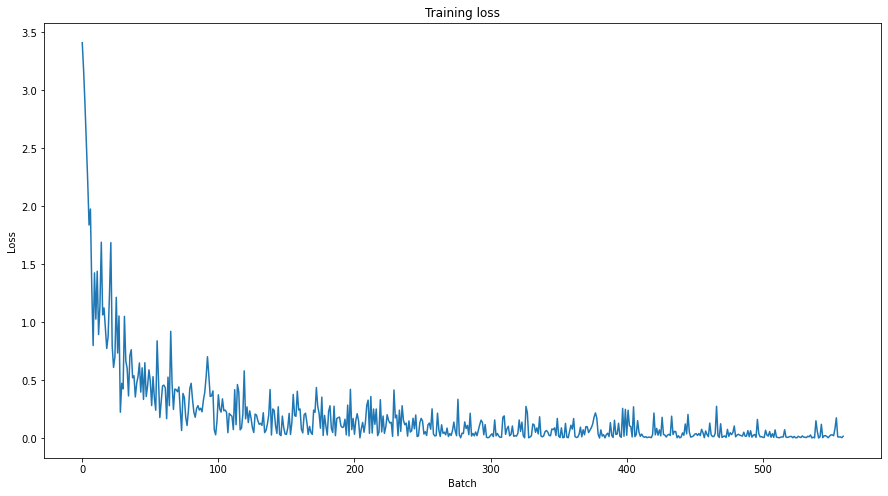

In [47]:
# loss를 시각화합니다. 
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

## Inference 

### 1. Test set Preprocess 
* inference 과정을 위해, test set을 input 형식에 맞추어 재가공합니다. 

In [48]:
# load test data
sentences = ["[CLS] " + query + " [SEP]" for query in query_data_test]
labels = intent_data_label_test

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

In [49]:
MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [50]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

In [51]:
# to tensor
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

In [52]:
batch_size = 32  

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

### 2. Evaluation 
* test set을 통해 모델이 적절한지 평가합니다. 

In [58]:
# ========================================
#                Predict
# ========================================

print("")
print("Test...")

# 시작 시간 설정
t0 = time.time()

# evaluation 
model.eval()

# tracking variables 
predictions , true_labels = [], []

# DataLoader 에서 batch 만큼 반복하여 가져옵니다. 
for batch in prediction_dataloader:
    
    # batch를 GPU에 올립니다. 
    batch = tuple(t.to(device) for t in batch)
    
    # batch에서 데이터를 추출합니다. 
    b_input_ids, b_input_mask, b_labels = batch
    
    # evaluation 단계 : gradient 업데이트 하지 않습니다. 
    with torch.no_grad():     
        # Forward 
        logits = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # 예측값과 실제값을 저장합니다. 
    predictions.append(logits)
    true_labels.append(label_ids)
    
print("")
print("Test took: {:}".format(format_time(time.time() - t0)))
print("Test complete!")


Test...

Test took: 0:00:04
Test complete!


In [59]:
# 성능 평가 : Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

matthews_corrcoef(flat_true_labels, flat_predictions)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.9447790903474139

### 3. Inference
* 학습한 결과를 통해, 새로운 문장이 들어왔을 때의 결과를 추론합니다. 

In [76]:
label_index = pd.DataFrame({'intent' : intent_data_train, 'label' : intent_data_label_train})

df_index_small = pd.DataFrame(columns=['intent', 'label'])
j = 0
for i in label_index.intent.unique():
    df_index_small.loc[j] = label_index[label_index.intent==i].iloc[0]
    j = j+1

In [79]:
# intent의 label dataframe 생성 
df_index_small.sort_values('label', ascending=True)

,intent,label
8,abbreviation,0
3,aircraft,1
21,aircraft+flight+flight_no,2
2,airfare,3
19,airfare+flight_time,5
6,airline,6
17,airline+flight_no,7
5,airport,8
13,capacity,9
20,cheapest,10


In [80]:
# 입력 데이터 변환
def convert_input_data(sentences):

    # tokenizing 
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    MAX_LEN = 128
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # padding
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # attention mask 
    attention_masks = []

    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # to pytorch tensor 
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

In [89]:
# 문장 테스트
def test_sentences(sentences):

    model.eval()

    # 문장을 입력 데이터로 변환합니다. 
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 올립니다. 
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)


    # inference  
    with torch.no_grad():     
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # prediction 
    logits = outputs.detach().cpu().numpy()

    # output 
    result = df_index_small[df_index_small["label"] == np.argmax(logits)]["intent"][0]

    print("* intent *")

    return result

In [90]:
test_sentences(['What is the Cheapest Flight from San Francisco to Boston?'])

* intent *


'flight'

## 참고자료
* BERT-for-dummies : https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03 
* BERT 톺아보기 : http://docs.likejazz.com/bert/